

# Logistic Regression with Python

For this lecture we will be working with the [Titanic Data Set from Kaggle](https://www.kaggle.com/c/titanic). This is a very famous data set and very often is a student's first step in machine learning! 

We'll be trying to predict a classification- survival or deceased.
Let's begin our understanding of implementing Logistic Regression in Python for classification.

We'll use a "semi-cleaned" version of the titanic data set, if you use the data set hosted directly on Kaggle, you may need to do some additional cleaning not shown in this lecture notebook.

## Import Libraries
Let's import some libraries to get started!

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## The Data

Let's start by reading in the titanic_train.csv file into a pandas dataframe.

In [26]:
train = pd.read_csv('titanic.csv', delimiter = '\t')

In [27]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Exploratory Data Analysis

Let's begin some exploratory data analysis! We'll start by checking out missing data!

## Missing Data

We can use seaborn to create a simple heatmap to see where we are missing data!

In [28]:
train.shape

(156, 12)

In [29]:
train.isnull().sum()  # cabin more than 40% data is missing so , we drop this column

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             30
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          125
Embarked         1
dtype: int64

<AxesSubplot:>

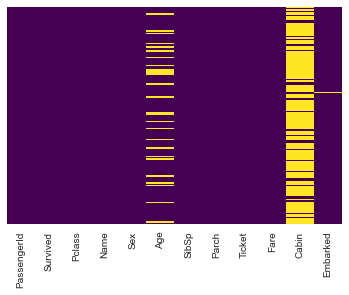

In [30]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this later, or change it to another feature like "Cabin Known: 1 or 0"

Let's continue on by visualizing some more of the data! Check out the video for full explanations over these plots, this code is just to serve as reference.

<AxesSubplot:xlabel='Survived', ylabel='count'>

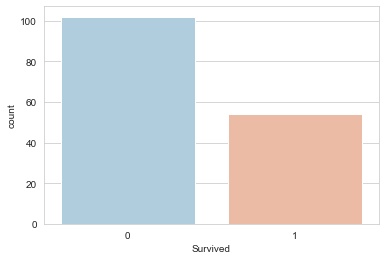

In [31]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train,palette='RdBu_r')

<AxesSubplot:xlabel='Survived', ylabel='count'>

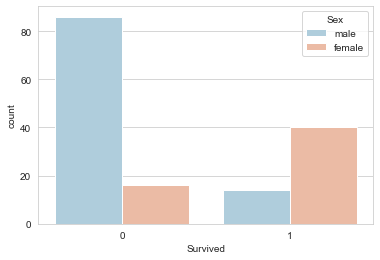

In [32]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')

<AxesSubplot:xlabel='Survived', ylabel='count'>

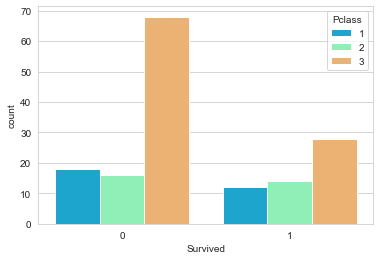

In [33]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')

<AxesSubplot:>

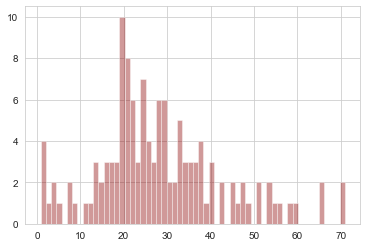

In [34]:
train['Age'].hist(bins=58,color='darkred',alpha=0.4)

<AxesSubplot:xlabel='SibSp', ylabel='count'>

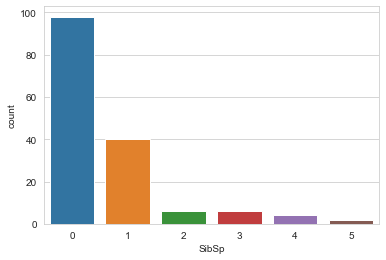

In [35]:
sns.countplot(x='SibSp',data=train)

<AxesSubplot:>

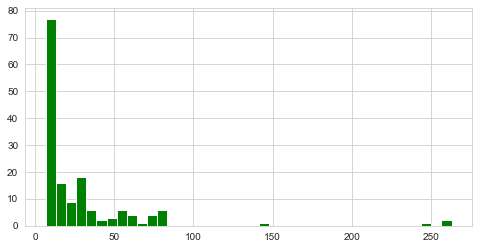

In [36]:
train['Fare'].hist(color='green',bins=40,figsize=(8,4))

___
## Data Cleaning
We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation).
However we can be smarter about this and check the average age by passenger class. For example:


<AxesSubplot:xlabel='Pclass', ylabel='Age'>

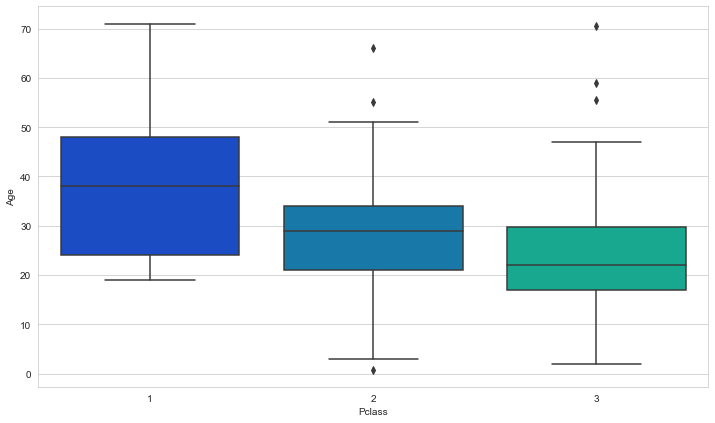

In [37]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

In [38]:
# Outlier Treatment

c1 = (train['Pclass']==3)&(train['Age']>42)
c2 = (train['Pclass']==2)&(train['Age']>50)
c3 = (train['Pclass']==2)&(train['Age']<8)

train['new age']=np.select([c1,c2,c3],[23,27,27], train['Age'])

<AxesSubplot:xlabel='Pclass', ylabel='new age'>

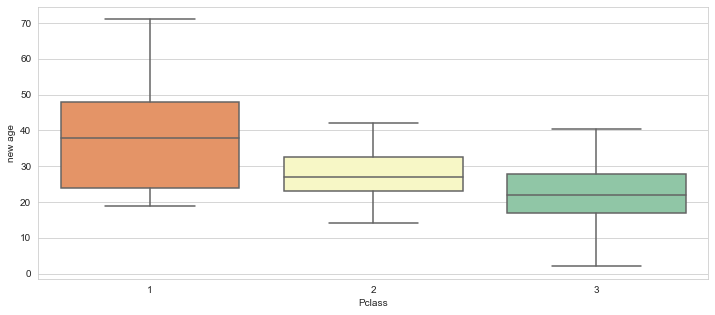

In [39]:
plt.figure(figsize=(12, 5))
sns.boxplot(x='Pclass',y='new age',data=train,palette='Spectral')

In [40]:
# Treat NAN values for AGE
train.Age.isna().sum() # 30 nan
train.Age.fillna(train.Age.median(), inplace = True)
train.Age.isna().sum() # 0 nan

0

In [41]:
# Treat NAN values for EMBARKD
train.Embarked.isna().sum() # 1 nan 
train.Embarked.mode()[0] # finding the most common occuring value from the column
train.Embarked.fillna(train.Embarked.mode()[0], inplace = True)
train.Embarked.isna().sum() # 0 nan

0

We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.

In [42]:
# treating Age NAN Values basied on PClass

def impute_age(cols):
    Age2 = cols[0]
    Pclass2 = cols[1]
    
    if pd.isnull(Age2):

        if Pclass2 == 1:
            return train[train['Pclass']==1]['Age'].median()

        elif Pclass2 == 2:
            return train[train['Pclass']==2]['Age'].median()

        else:
            return train[train['Pclass']==3]['Age'].median()

    else:
        return Age2

In [43]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)

<AxesSubplot:>

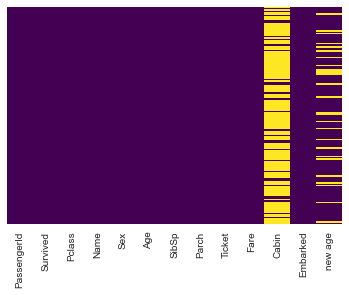

In [44]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Great! Let's go ahead and drop the Cabin column and the row in Embarked that is NaN.

In [45]:
train.drop('Cabin',axis=1,inplace=True)

In [46]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,new age
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,22.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,38.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,26.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,35.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,35.0


In [47]:
train.dropna(inplace=True)

## Converting Categorical Features 

We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [48]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126 entries, 0 to 155
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  126 non-null    int64  
 1   Survived     126 non-null    int64  
 2   Pclass       126 non-null    int64  
 3   Name         126 non-null    object 
 4   Sex          126 non-null    object 
 5   Age          126 non-null    float64
 6   SibSp        126 non-null    int64  
 7   Parch        126 non-null    int64  
 8   Ticket       126 non-null    object 
 9   Fare         126 non-null    float64
 10  Embarked     126 non-null    object 
 11  new age      126 non-null    float64
dtypes: float64(3), int64(5), object(4)
memory usage: 12.8+ KB


In [49]:
train = pd.get_dummies(train, columns = ['Sex', 'Embarked'],drop_first=True)

In [50]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,new age,Sex_male,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,22.0,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,38.0,0,0,0


# Building a Logistic Regression model

Let's start by splitting our data into a training set and test set (there is another test.csv file that you can play around with in case you want to use all this data for training).

## Train Test Split

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(['Survived','Age','Name','Ticket','PassengerId'],axis=1), 
                                                    train['Survived'], test_size=0.30, 
                                                    random_state=101)

## Training and Predicting

In [53]:
from sklearn.linear_model import LogisticRegression

In [54]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

C:\Users\sagarsah\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [55]:
X_test.head()

,Pclass,SibSp,Parch,Fare,new age,Sex_male,Embarked_Q,Embarked_S
102,1,0,1,77.2875,21.0,1,0,1
41,2,1,0,21.0000,27.0,0,0,1
57,3,0,0,7.2292,28.5,1,0,0
58,2,1,2,27.7500,27.0,0,0,1
75,3,0,0,7.6500,25.0,1,0,1


In [56]:
predictions = logmodel.predict(X_test)

In [57]:
y_test.head()

102    0
41     0
57     0
58     1
75     0
Name: Survived, dtype: int64

In [58]:
predictions[:5]

array([0, 1, 0, 1, 0], dtype=int64)

In [59]:
logmodel.predict(np.array([[3,0,0,7,21,1,0,1]]))

array([0], dtype=int64)

In [60]:
logmodel.predict(X_test.iloc[0:2].values)

array([0, 1], dtype=int64)

In [61]:
logmodel.predict(np.array([[ 1. , 50. ,  1. ,   1,  13,  0 ,  0 ,  0]]))

array([0], dtype=int64)

## Evaluation

We can check precision,recall,f1-score using classification report!

In [62]:
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score, f1_score, confusion_matrix,classification_report

In [63]:
precision_score(y_test,predictions)  # 3

0.5625

In [64]:
recall_score(y_test,predictions)  # 2

0.8181818181818182

In [65]:
accuracy_score(y_test,predictions)  # 4

0.7631578947368421

In [66]:
f1_score(y_test,predictions)   # 1

0.6666666666666666

In [73]:
confusion_matrix(y_test,predictions)

array([[20,  7],
       [ 2,  9]], dtype=int64)

In [74]:
%%time
import pickle
# # saved the trained model in file with given name
pickle_out = open("titanic_pred.pickle","wb") # name of my pickle file , wb -write
pickle.dump(logmodel, pickle_out)
pickle_out.close()

Wall time: 975 µs


In [75]:
# loading the pickeled model
pickle_in = open("titanic_pred.pickle","rb") # rb -> read the pickel file
trained_model = pickle.load(pickle_in)
trained_model.predict(X_test)

array([0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1], dtype=int64)

In [70]:
trained_model.predict(np.array([[3,0,0,7,21,1,0,1]]))

array([0], dtype=int64)

In [76]:
X_test.head(1)

,Pclass,SibSp,Parch,Fare,new age,Sex_male,Embarked_Q,Embarked_S
102,1,0,1,77.2875,21.0,1,0,1


In [77]:
trained_model.predict(np.array([[1,55,0,1,150,55,1,0,0]]))

ValueError: X has 9 features per sample; expecting 8